# Connectome Prediction: Model Comparison Analysis
This notebook presents a complete evaluation of three predictive models—**MLP_coords**, **MLP_cls**, and **SMT_cls**—for predicting brain connectivity using gene expression and spatial coordinates. The analysis includes metric summaries, statistical testing, and interactive visualizations of functional subnetwork performance.

In [16]:
# Load required packages and datasets
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel, f_oneway
from statsmodels.stats.multitest import multipletests
import plotly.graph_objects as go

# Load metric results
euclidean_df = pd.read_csv('./euclidean_CV.csv')
mlp_cls_df = pd.read_csv('./mlp_cls_3layer.csv')
smt_cls_df = pd.read_csv('./smt_cls_3layer.csv')


## Metric Summary Table

In [17]:
metrics = [
    'final_test_metrics.pearson_r', 'final_test_metrics.short_r', 'final_test_metrics.mid_r', 'final_test_metrics.long_r',
    'final_test_metrics.mse', 'final_test_metrics.r2', 'final_test_metrics.geodesic_distance'
]
rename = {
    'final_test_metrics.pearson_r': 'Pearson-r', 'final_test_metrics.short_r': 'Short-r',
    'final_test_metrics.mid_r': 'Mid-r', 'final_test_metrics.long_r': 'Long-r',
    'final_test_metrics.mse': 'MSE', 'final_test_metrics.r2': 'R²',
    'final_test_metrics.geodesic_distance': 'Geodesic Distance'
}

def format_stats(df):
    return df[metrics].rename(columns=rename).agg(['mean', 'std']).T.apply(
        lambda x: f"{x['mean']:.3f} ± {x['std']:.3f}", axis=1
    )

summary = pd.DataFrame({
    'MLP_coords': format_stats(euclidean_df),
    'MLP_cls': format_stats(mlp_cls_df),
    'SMT_cls': format_stats(smt_cls_df)
})
summary

,MLP_coords,MLP_cls,SMT_cls
Pearson-r,0.689 ± 0.061,0.818 ± 0.029,0.827 ± 0.026
Short-r,0.726 ± 0.060,0.840 ± 0.026,0.845 ± 0.025
Mid-r,0.630 ± 0.068,0.789 ± 0.033,0.801 ± 0.028
Long-r,0.565 ± 0.095,0.742 ± 0.066,0.768 ± 0.059
MSE,0.018 ± 0.003,0.011 ± 0.001,0.011 ± 0.002
R²,0.476 ± 0.083,0.658 ± 0.051,0.673 ± 0.048
Geodesic Distance,13.144 ± 1.210,10.042 ± 0.946,9.535 ± 0.776


## Repeated-Measures ANOVA Across All Models

In [18]:
anova_results = {}
for m in metrics:
    f_val, p_val = f_oneway(euclidean_df[m], mlp_cls_df[m], smt_cls_df[m])
    anova_results[m] = {'F-statistic': f_val, 'p-value': p_val}
anova_df = pd.DataFrame(anova_results).T
anova_df['Adjusted p-value'] = multipletests(anova_df['p-value'], method='fdr_bh')[1]
anova_df['Significant'] = anova_df['Adjusted p-value'] < 0.05
anova_df.rename(index=rename)

,F-statistic,p-value,Adjusted p-value,Significant
Pearson-r,138.947840,1.243522e-31,2.901551e-31,True
Short-r,111.199630,8.755596e-28,1.021486e-27,True
Mid-r,168.847438,3.252740e-35,2.276918e-34,True
Long-r,87.158554,6.659820e-24,6.659820e-24,True
MSE,126.911020,4.928206e-30,8.624360e-30,True
R²,123.407588,1.504338e-29,2.106073e-29,True
Geodesic Distance,154.749043,1.376332e-33,4.817164e-33,True


In [21]:
# Full list of extended test metrics
extended_metrics = [
    'final_test_metrics.pearson_r', 'final_test_metrics.short_r', 'final_test_metrics.mid_r',
    'final_test_metrics.long_r', 'final_test_metrics.mse', 'final_test_metrics.r2',
    'final_test_metrics.geodesic_distance', 'final_test_metrics.left_hemi_r',
    'final_test_metrics.right_hemi_r', 'final_test_metrics.inter_hemi_r',
    'final_test_metrics.Cerebellum_r', 'final_test_metrics.Cont_r', 'final_test_metrics.Default_r',
    'final_test_metrics.DorsAttn_r', 'final_test_metrics.Limbic_r',
    'final_test_metrics.SalVentAttn_r', 'final_test_metrics.SomMot_r',
    'final_test_metrics.Subcortical_r', 'final_test_metrics.Vis_r'
]
from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests
import numpy as np
import pandas as pd

anova_results_all = {}
for metric in extended_metrics:
    a = euclidean_df[metric].dropna()
    b = mlp_cls_df[metric].dropna()
    c = smt_cls_df[metric].dropna()

    # Ensure equal length by aligning indices
    common_idx = a.index.intersection(b.index).intersection(c.index)
    if len(common_idx) == 0:
        anova_results_all[metric] = {'F-statistic': np.nan, 'p-value': np.nan}
        continue
    
    f_val, p_val = f_oneway(a.loc[common_idx], b.loc[common_idx], c.loc[common_idx])
    anova_results_all[metric] = {'F-statistic': f_val, 'p-value': p_val}

anova_df_all = pd.DataFrame(anova_results_all).T

# Apply correction only to valid (non-NaN) p-values
valid_p = anova_df_all['p-value'].dropna()
adjusted_p = pd.Series(np.nan, index=anova_df_all.index)
adjusted_p[valid_p.index] = multipletests(valid_p, method='fdr_bh')[1]

anova_df_all['Adjusted p-value'] = adjusted_p
anova_df_all['Significant'] = anova_df_all['Adjusted p-value'] < 0.05

anova_df_all

,F-statistic,p-value,Adjusted p-value,Significant
final_test_metrics.pearson_r,138.947840,1.243522e-31,4.725383e-31,True
final_test_metrics.short_r,111.199630,8.755596e-28,2.079454e-27,True
final_test_metrics.mid_r,168.847438,3.252740e-35,6.180207e-34,True
final_test_metrics.long_r,87.158554,6.659820e-24,1.150333e-23,True
final_test_metrics.mse,126.911020,4.928206e-30,1.560599e-29,True
final_test_metrics.r2,123.407588,1.504338e-29,4.083204e-29,True
final_test_metrics.geodesic_distance,154.749043,1.376332e-33,1.307516e-32,True
final_test_metrics.left_hemi_r,142.758784,4.064056e-32,1.930427e-31,True
final_test_metrics.right_hemi_r,91.628259,1.136488e-24,2.159328e-24,True
final_test_metrics.inter_hemi_r,148.793254,7.217482e-33,4.571072e-32,True


## Post-hoc Paired T-Tests Between MLP_cls and SMT_cls

In [22]:
ttest_results = {}
for m in metrics:
    stat, pval = ttest_rel(mlp_cls_df[m], smt_cls_df[m])
    ttest_results[m] = {'t-stat': stat, 'p-value': pval}
ttest_df = pd.DataFrame(ttest_results).T
ttest_df['Adjusted p-value'] = multipletests(ttest_df['p-value'], method='fdr_bh')[1]
ttest_df['Significant'] = ttest_df['Adjusted p-value'] < 0.05
ttest_df.rename(index=rename)

,t-stat,p-value,Adjusted p-value,Significant
Pearson-r,-3.211460,0.002646,0.006175,True
Short-r,-1.424211,0.162338,0.162338,False
Mid-r,-3.438130,0.001407,0.004925,True
Long-r,-4.409696,0.000079,0.000553,True
MSE,2.711002,0.009922,0.011576,True
R²,-2.910333,0.005938,0.010392,True
Geodesic Distance,2.783101,0.008258,0.011562,True


In [23]:
# Paired t-tests between MLP_cls and SMT_cls across all extended metrics
ttest_results_all = {}
for metric in extended_metrics:
    stat, pval = ttest_rel(mlp_cls_df[metric], smt_cls_df[metric], nan_policy='omit')
    ttest_results_all[metric] = {'t-statistic': stat, 'p-value': pval}

ttest_df_all = pd.DataFrame(ttest_results_all).T
ttest_df_all['Adjusted p-value'] = multipletests(ttest_df_all['p-value'], method='fdr_bh')[1]
ttest_df_all['Significant'] = ttest_df_all['Adjusted p-value'] < 0.05
ttest_df_all

,t-statistic,p-value,Adjusted p-value,Significant
final_test_metrics.pearson_r,-3.211460,0.002646,0.015012,True
final_test_metrics.short_r,-1.424211,0.162338,0.210375,False
final_test_metrics.mid_r,-3.438130,0.001407,0.013368,True
final_test_metrics.long_r,-4.409696,0.000079,0.001501,True
final_test_metrics.mse,2.711002,0.009922,0.026932,True
final_test_metrics.r2,-2.910333,0.005938,0.022566,True
final_test_metrics.geodesic_distance,2.783101,0.008258,0.026151,True
final_test_metrics.left_hemi_r,1.853964,0.071319,0.123187,False
final_test_metrics.right_hemi_r,-1.944943,0.059018,0.112134,False
final_test_metrics.inter_hemi_r,-3.146497,0.003160,0.015012,True


## Global Metric Improvements: Paired Slope Plots

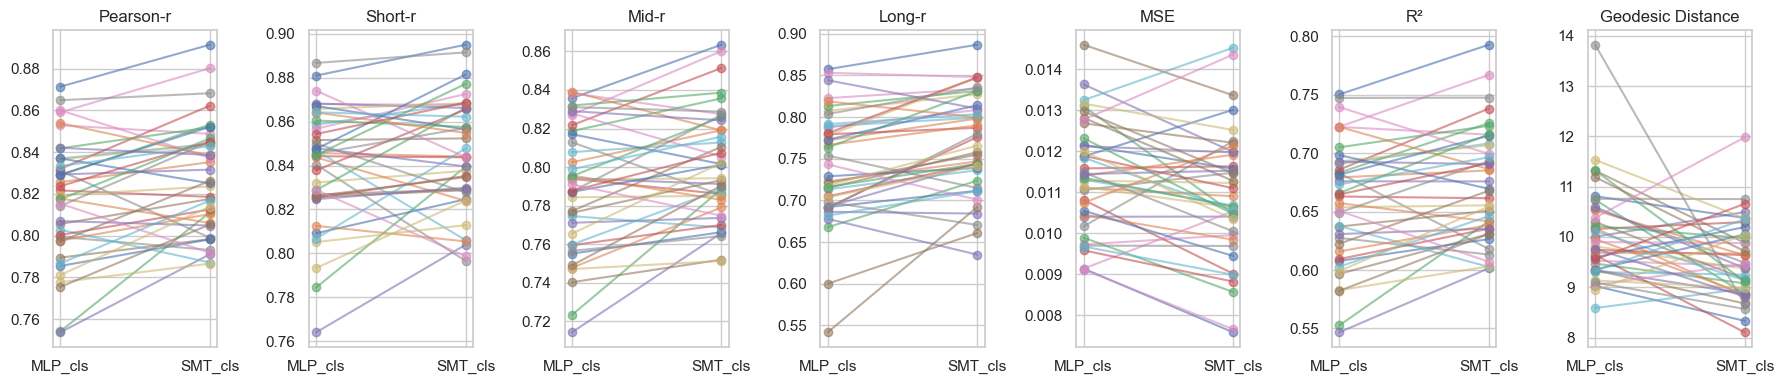

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
fig, axes = plt.subplots(1, len(metrics), figsize=(18, 4))
for i, m in enumerate(metrics):
    axes[i].plot([0, 1], [mlp_cls_df[m], smt_cls_df[m]], 'o-', alpha=0.6)
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['MLP_cls', 'SMT_cls'])
    axes[i].set_title(rename[m])
plt.tight_layout()

## Interactive 3D Subnetwork Visualization